<a href="https://colab.research.google.com/github/dewdotninja/embedded_iot/blob/master/supplement/level_shifter_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This design was originally a midterm exam problem 

In [1]:
# import libraries you want to use
import numpy as np
import matplotlib.pyplot as plt

<a id="p8"></a>
#### P8. (10 points)(level 3)
Write a Python function to solve an arbitrary level-shifter circuit in Figure 8

<code>
R1, R2, R3, R4, Vb = level_shifter_design(vi_min, vi_max, vo_min, vo_max)
</code>

<p />With a set of specified min/max of $V_{in}$ and $V_{out}$, the function must choose the resistors and $V_B$ and also 
plot the input and output ranges to verify that the design is correct. None of the resistor output should be negative. 
If R3 and R4 are not needed, R3 is set to zero and R4 to a high value such as $10 M\Omega$.

<p />Validate your design with a set of arbitrary arguments. No assumption that any of the input or output should have
zero average.

<p align="center">
<img src="https://raw.githubusercontent.com/dewdotninja/sharing-github/master/level_shifter.jpg" width=650 
alt="Figure 8"/>
</p>
<div align="center"><b>Figure 8 level shifter circuit</b></div>


#### Solution

The equation of level shifter is

$$
V_{out} = \rho(1+k)V_{in}-kV_B
$$
<div align="right">(1)</div>

where 

$$
k = \frac{R_2}{R_1} \\
\rho = \frac{R_4}{R_3+R_4}
$$

Let $V_{id}=V_{imax}-V_{imin}$ and $V_{od}=V_{omax}-V_{omin}$ represent input and output voltage range, respectively. 
This problem can be separated 
to 2 cases

#### A. When $V_{id} \lt V_{od}$

Amplification is needed. $R_3 = 0$, $R_4 = 10 M\Omega \Rightarrow \rho = 1$. <div align="right">(2)</div>

let $g = \frac{V_{od}}{V_{id}}$, so $1+k = g \Rightarrow k = g-1$ (pick $R_1$ and compute $R_2$)  <div align="right">(3)</div>

The only parameter left is $V_B$ which is used to adjust the output offset to the desired level.

Let $V_{ia} = V_{imax}-0.5*V_{id}, V_{oa} = V_{omax}-0.5*V_{od}$ be the input and desired output average levels, 
respectively.

With non-inverting gain $g$, the output middle level will be $V_{om} = g*V_{ia}$. So we need to compensate that level
 to yield $V_{oa}$ by using the term $-kV_B$ in (1). Hence
    
$$
kV_B = V_{om}  - V_{oa} 
$$

$$
V_B = (V_{om} - V_{oa})/k
$$
<div align="right">(4)</div>

To summarize, use (2) to specify  $R_3 = 0$, $R_4 = 10 M\Omega$, (3) for $R_1, R_2$, and (4) for $V_B$   
    
#### B. When $V_{id} \ge V_{od}$

Voltage divider must be used. Note that we cannot set $k=0$ becuase we want to use the inverting part in (1). So 
set 
$$
k=1 \Rightarrow R_1 = R_2
$$ 
<div align="right">(5)</div> 

and use the voltage divider to adjust the overall attenuation, 
which is $g = \frac{V_{od}}{V_{id}}$. Hence,

$$
g = 2\rho
$$

$$
\rho = 0.5g
$$

This solves for $R3,R4$ (pick one and compute the other). <div align="right">(6)</div>

Then, use $V_B$ to adjust the offset level as in case A; i.e.,
$$
V_B = V_{om}  - V_{oa} 
$$
<div align="right">(7)</div>





In [2]:
def level_shifter_design(vi_min, vi_max, vo_min, vo_max):
    v_id = vi_max - vi_min  # input range
    v_ia = vi_max - 0.5*v_id  # average of input
    v_od = vo_max - vo_min  # output range
    v_oa = vo_max - 0.5*v_od # desired avearge of output
    g = v_od/v_id  # desired amplification/attenuation
    
    if g > 1: # case A : amplification
        print("Case A : amplification")
        k = g - 1  # k = R2/R1
        rho = 1
        R4 = 10e6  # high value to make sure input impedance remains high
        R3 = 0     # This means voltage divider is just a pass through (2)
        R1 = 10000  # choose a practical value for R1 
        R2 = k*R1   # solve for R2 using (3)
        v_om = g*v_ia  # middle level of output without V_B
        VB = (v_om - v_oa)/k  # compute V_B to achieve required offset
    else: # case B : attenuation
        print("Case B : attenuation")
        k = 1   # i.e., R1 = R2
        R1 = 10000  # choose practical values
        R2 = 10000
        rho = 0.5*g 
        R3 = 10000  # choose practical value for R3
        R4 = R3*rho/(1-rho)  # solve for R4 using (6)
        v_om = g*v_ia  # middle level of output without V_B
        VB = v_om - v_oa  # (7)
   
    # plot input and output to verify the design
    tvec = np.arange(0,1,0.01)
    w = 10
    Vin = 0.5*v_id*np.sin(w*tvec)+v_ia
    Vout = rho*(1+k)*Vin - k*VB  #(1)    
    Vin_min = min(Vin)  # print values on graph for easy verification    
    Vin_min_txt = "min={:.2f} Volts".format(Vin_min)
    Vin_max = max(Vin)
    Vin_max_txt = "max={:.2f} Volts".format(Vin_max)
    Vout_min = min(Vout)
    Vout_min_txt = "min={:.2f} Volts".format(Vout_min)
    Vout_max = max(Vout)
    Vout_max_txt = "max={:.2f} Volts".format(Vout_max)
    
    fig, (ax1, ax2) = plt.subplots(2,figsize=(8,8))
    fig.suptitle('Level shifter design verification')
    ax1.plot(tvec,Vin,'b-')
    ax1.grid(True)
    ax1.set_ylabel('$V_{in}(t)$')
    ax1.text(0.52,Vin_min,Vin_min_txt)
    ax1.text(0.2,Vin_max,Vin_max_txt)
    
    ax2.plot(tvec,Vout,'r-')
    ax2.set_xlabel('time (s)')
    ax2.set_ylabel('$V_{out}(t)$')
    ax2.grid(True)
    ax2.text(0.52,Vout_min,Vout_min_txt)
    ax2.text(0.2,Vout_max,Vout_max_txt)

    print("Design yields R1 = {:.2f}, R2 = {:.2f}, R3 = {:.2f},R4 = {:.2f} Ohms, VB = {:.2f} Volts".format(R1,R2,R3,R4,VB))
    return R1, R2, R3, R4, VB
        

Case B : attenuation
Design yields R1 = 10000.00, R2 = 10000.00, R3 = 10000.00,R4 = 899.18 Ohms, VB = -1.65 Volts


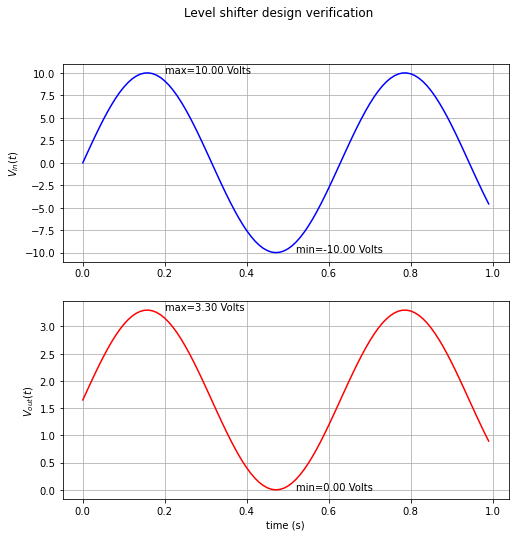

In [3]:
# Test 1 : Vin = [-10,10] V, Vout = [0,3.3] V (Ex. analog input for servo motor to MCU)
R1,R2,R3,R4,VB = level_shifter_design(vi_min = -10,vi_max = 10, vo_min=0, vo_max=3.3)

Case A : amplification
Design yields R1 = 10000.00, R2 = 5151.52, R3 = 0.00,R4 = 10000000.00 Ohms, VB = 4.85 Volts


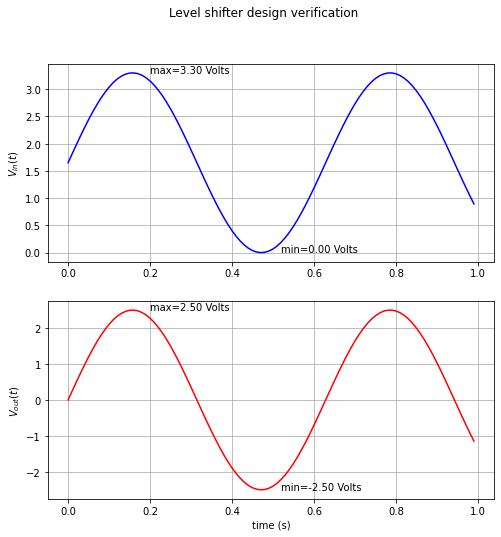

In [5]:
# Test 2 : Vin = [0, 3.3] V, Vout = [-2.5,2.5] V (From MCU output to some audio circuit)
R1,R2,R3,R4,VB = level_shifter_design(vi_min = 0,vi_max = 3.3, vo_min=-2.5, vo_max=2.5)

Case A : amplification
Design yields R1 = 10000.00, R2 = 156666.67, R3 = 0.00,R4 = 10000000.00 Ohms, VB = -0.01 Volts


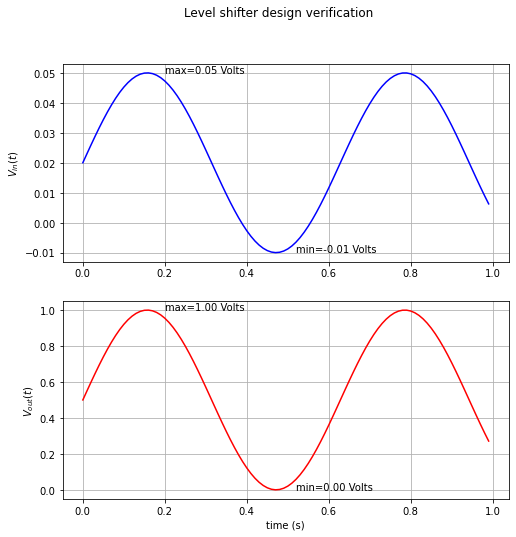

In [6]:
# Test 3 : Vin = [-0.01,0.05] V, Vout = [0, 1] V  (weak signal from a sensor to ADC of ESP8266)
R1,R2,R3,R4,VB = level_shifter_design(vi_min = -0.01,vi_max = 0.05, vo_min=0, vo_max=1)

Test using vi_min = 3.45, vi_max = 3.80, vo_min = 7.25, vo_max = 8.70 volts
Case A : amplification
Design yields R1 = 10000.00, R2 = 32149.19, R3 = 0.00,R4 = 10000000.00 Ohms, VB = 2.27 Volts


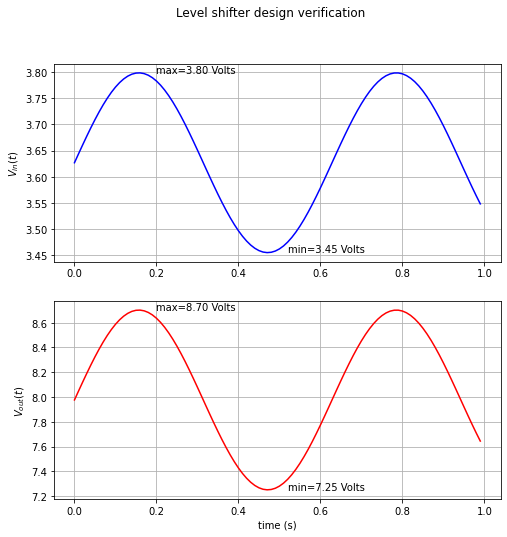

In [8]:
# Test 4 : Vin = [vi_min, vi_max] V, Vout = [vo_min, vo_max] V (random Vin, Vout in the range +/- 10, only require Vmin < Vmax
# for both input and output.)
# Run this cell as often as you like.

# generate random input and output limits
vi_min = 10*(np.random.rand() - np.random.rand())
vi_max = -10
while vi_max < vi_min: # make sure vi_max > vi_min
    vi_max = 10*(np.random.rand() - np.random.rand())

vo_min = 10*(np.random.rand() - np.random.rand())
vo_max = -10
while vo_max < vo_min: # make sure vo_max > vo_min
    vo_max = 10*(np.random.rand() - np.random.rand())
print("Test using vi_min = {:.2f}, vi_max = {:.2f}, vo_min = {:.2f}, vo_max = {:.2f} volts".format(vi_min, vi_max, vo_min, vo_max))


R1,R2,R3,R4,VB = level_shifter_design(vi_min = vi_min,vi_max = vi_max, vo_min=vo_min, vo_max=vo_max)
    

#### Update list:

Oct 9, 2023:

- fix sign error on R4 computation. Originally, 
```python
R4 = R3*rho/(1+rho)
```
is incorrect. It should be 
```
R4 = R3*rho/(1-rho)
```

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja<br>Copyright 2021</div>